# Practical Deep Learning Workshop 2021
## Assignment 2 part 1 - PAMAP2 Physical Activity Monitoring Data Set
 
### Authors:
 
1.   Naor Kolet 205533060
2.   Chen Doytshman 205644941

# 0. Imports

In [8]:
import pandas as pd
import numpy as np
 
# TensorFlow
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import Input, BatchNormalization, Concatenate, Dropout
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
import tensorflow as tf

# Scikit-learn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier

# Plots
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Misc.
import pickle
import os
import time
import random
import joblib
from tqdm import tqdm_notebook as tqdm

SEED = 42
%matplotlib inline

In [9]:
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 1. Exploratory Data Analysis (EDA)

## a. General exploratory of the data

### 1.1 Dataset Description

The PAMAP2 Physical Activity Monitoring dataset contains data of 18 different physical activities (such as walking, cycling, playing soccer, etc.), performed by 9 subjects wearing 3 inertial measurement units and a heart rate monitor. The dataset can be used for activity recognition and intensity estimation, while developing and applying algorithms of data processing, segmentation, feature extraction and classification.

### 1.2 Data Load

First we will load the data to a dictionary.

In [10]:
num_feat_imu = 18
dat_files = [_ for _ in os.listdir('./PAMAP2_Dataset/Protocol') if _.endswith(".dat")]
columns = ['timestamp', 'activityID', 'heart_rate']
columns += [f'IMU_hand{i}' for i in range(1, num_feat_imu)]
columns += [f'IMU_chest{i}' for i in range(1, num_feat_imu)]
columns += [f'IMU_ankle{i}' for i in range(1, num_feat_imu)]
subjects = {subject.split('.')[0][-3:]: pd.read_csv(f'./PAMAP2_Dataset/Protocol/{subject}', sep=' ', names=columns) for subject in dat_files}

for subject, df in subjects.items():
    df['ID'] = subject
    df.set_index(['ID', 'timestamp'], inplace=True)

Let's define a dictionary that will map activity ID to activity name.

In [11]:
id2activity = {
    1: 'lying',
    2: 'sitting',
    3: 'standing',
    4: 'walking',
    5: 'running',
    6: 'cycling',
    7: 'Nordic walking',
    9: 'watching TV',
    10: 'computer work',
    11: 'car driving',
    12: 'ascending stairs',
    13: 'descending stairs',
    16: 'vacuum cleaning',
    17: 'ironing',
    18: 'folding laundry',
    19: 'house cleaning',
    20: 'playing soccer',
    24: 'rope jumping',
    0: 'in transition'
}

### 1.3 Preprocessing

According to the dataset documentation, data labeled with activityID=0 should be discarded in any kind of analysis. This data mainly covers transient activities between performing different activities, so we better remove it before we continue.

In [12]:
def remove_zero_activity(subjects):
    return {subject : df[df['activityID']!= 0] for subject, df in subjects.items()}

subjects = remove_zero_activity(subjects)

According to the dataset documentation, some missing values (```NaNs```) are present due to wireless communication dropping or due to problems with hardware setup. We will perform data imputation to fill those missing values using linear interpolation.

In [13]:
def impute(subjects):
    return {subject : df.interpolate(method='linear').bfill() for subject, df in subjects.items()}

subjects = impute(subjects)

The values of 'activityID' are not in a continuous range, so we will reindex those values

In [14]:
act_vals = subjects['101']['activityID'].unique()
act_vals.sort()
print(f"Original `activityID` values: \t{act_vals}")
act_vals_map = {n : i for i,n in enumerate(np.unique(act_vals))}
print(f"New `activityID` values: \t{np.array(list(act_vals_map.values()))}")

Original `activityID` values: 	[ 1  2  3  4  5  6  7 12 13 16 17 24]
New `activityID` values: 	[ 0  1  2  3  4  5  6  7  8  9 10 11]


In [15]:
id2activity = {act_vals_map[actId]: actStr for actId, actStr in id2activity.items() if actId in act_vals}

In [16]:
def transform_activityId(df):
    df['activityID'] = df['activityID'].map(act_vals_map)

_ = [transform_activityId(df) for df in subjects.values()]

### 1.4 Data size, structure, samples, etc.

Let's review the structure of the data across subjects.

In [17]:
print(f'We have {len(subjects)} subjects in our dataset.')
print(f'Each subject is being measured by {list(subjects.values())[0].shape[1]} metrics.')
print()
print('Number of samples varies across subjects as follows:')
print('----------------------------------------------------')
_ = [print(f'Subject {subject} has {df.shape[0]} samples') for subject, df in subjects.items()]

We have 9 subjects in our dataset.
Each subject is being measured by 53 metrics.

Number of samples varies across subjects as follows:
----------------------------------------------------
Subject 101 has 249957 samples
Subject 102 has 263349 samples
Subject 103 has 174338 samples
Subject 104 has 231421 samples
Subject 105 has 272442 samples
Subject 106 has 250096 samples
Subject 107 has 232776 samples
Subject 108 has 262102 samples
Subject 109 has 6391 samples


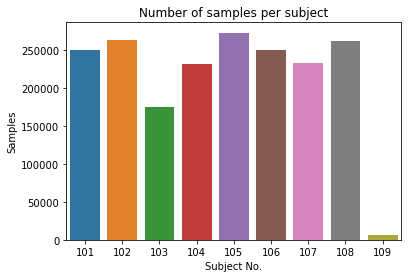

In [18]:
ax = sns.barplot(x=list(subjects.keys()), y=[subject.shape[0] for subject in subjects.values()])
ax.set_title('Number of samples per subject')
ax.set_xlabel('Subject No.')
ax.set_ylabel('Samples')
plt.show()

Now let's see how activities are distributed across each subjects.

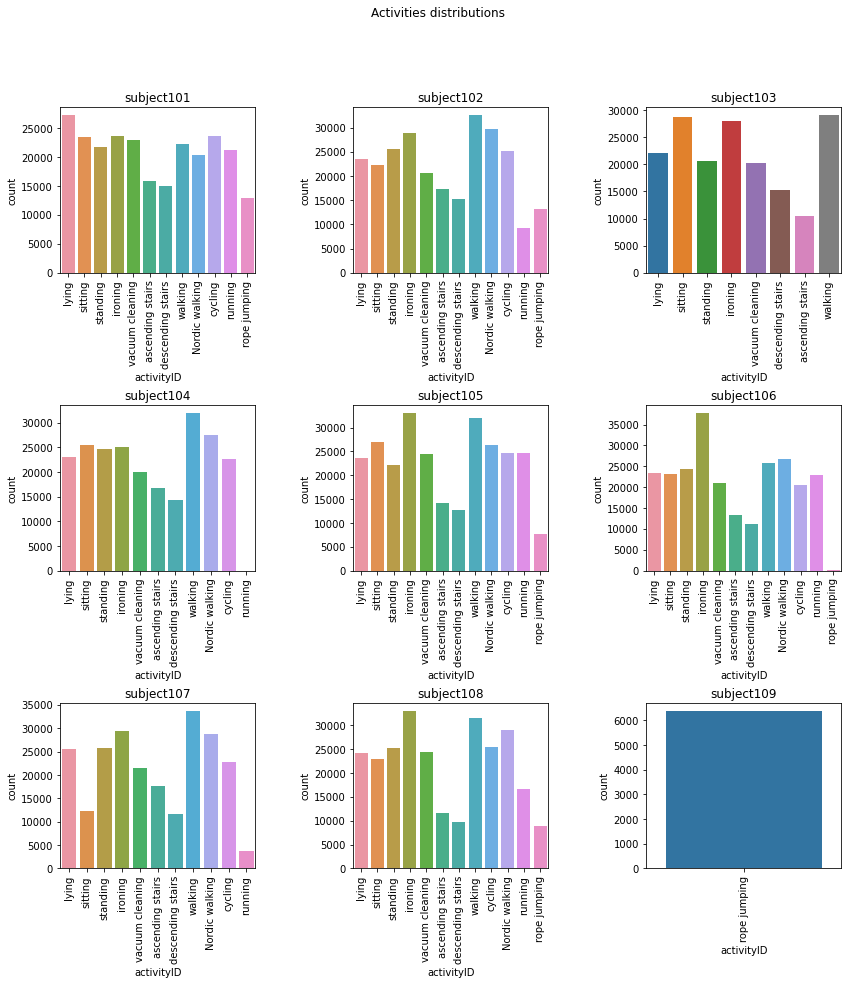

In [19]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(14,14))
fig.subplots_adjust(hspace=0.8, wspace=0.5)
fig.suptitle(f'Activities distributions')

for i in range(3):
    for j in range(3):
        curr_subject = i*3 + j + 1
        curr_subject = f'10{curr_subject}'
        subject_df = subjects[curr_subject]
        sns.countplot(x=subject_df['activityID'].map(id2activity), ax=ax[i][j])
        ax[i][j].set_title(f'subject{curr_subject}')
        ax[i][j].tick_params(axis='x', labelrotation= 90)

### 1.5 Available Benchmarks

We identified several benchmark results to rely on.


1.  [Colegues from previous semester](https://www.kaggle.com/avrahamcalev/time-series-models-pamap2-dataset) achieved 92.54% accuracy on the test data, using a combination of LSTM, intermediate dense layers and dropout regularization.
2. [This paper](https://www.researchgate.net/figure/7-Benchmark-on-the-PAMAP2-dataset-performance-measures-on-the-Basic-activity_tbl6_260291508/download) achieved almost perfectly on PAMAP. It's good for benchmark, although it is academic paper and we know a lost of effort has been made to achieve those results.

## b. Explain the task at hand

We will define the task as a classification task.
Since the order of the activities is known beforehand there is no need to predict the future activity given the past or the other way around.
We will divide the samples into time series, each record will have one unique activity.
Our mission will be, given the measurements, to predict the activity. In other words, given a window of x measurements, we wish to predict what was the activity that the subject performed during that window.

One intersting feature of this dataset is heart rate. Let's see how it varies depending on the activity.

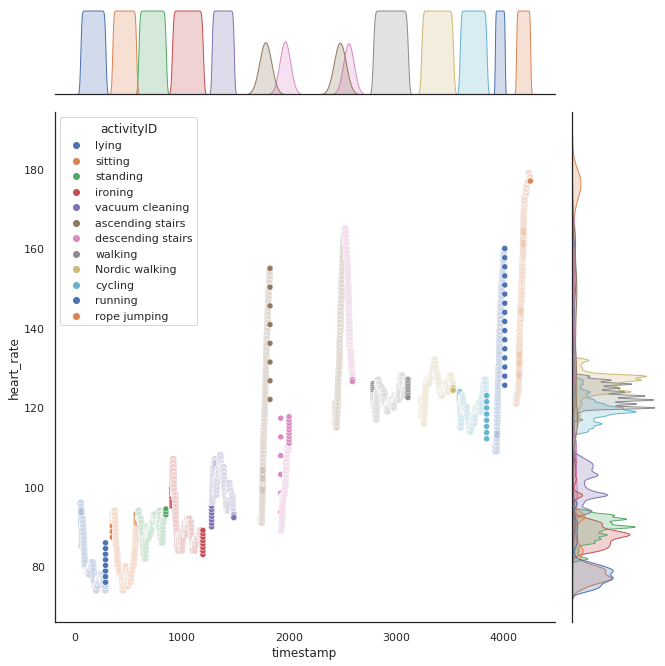

In [20]:
sns.set_theme(style='white')

joint = sns.jointplot(data=subjects['102'],
                x='timestamp', 
                y='heart_rate', 
                hue=subjects['102']['activityID'].map(id2activity), 
                palette='deep')
joint.fig.set_figwidth(10)
joint.fig.set_figheight(10)

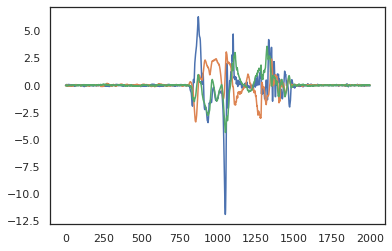

In [21]:
d = subjects['102'][:2000]
_ = plt.plot(d['IMU_hand8'].values)
_ = plt.plot(d['IMU_hand9'].values)
_ = plt.plot(d['IMU_hand10'].values)


## c. State self-supervised tasks 

Two self-supervised tasks we can think of are the following:

1. Predicting the heart rate of a subject based on its sensory information (IMU's). This is a regression task, but it is quite easy so we will try our best in a most challenging task, which is stated below.

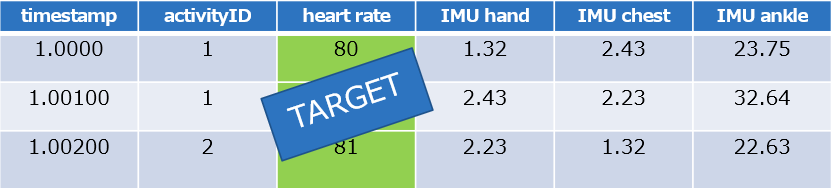

2. Predicting the temprature and first acceleration data of the chest, based on other features. This is also a regression task and we will do it by considering past window examples (```look_back```) and future samples (```look_after```) to best predict our target.

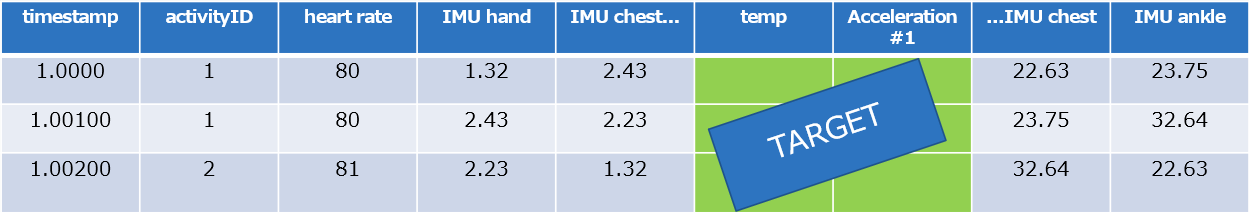

# 2. Forming neural network

## a. The validation strategy 

We have data regarding 9 subjects. As stated in the assignment specification, subjects 107, 108 will be used as our test set. For validation set will will use another two random subjects. It is convinient and easy to understand, and ressembles the test set.

In [22]:
sbjcts = list(subjects.keys())
val_size = 2

test_subjects = ['107', '108']
random.seed(SEED)
val_subjects = random.sample([sbj for sbj in sbjcts if sbj not in test_subjects], val_size)

train_subjects = [sbj for sbj in sbjcts if sbj not in test_subjects+val_subjects]

print('train subjects:\t\t', " ".join(train_subjects))
print('validation subjects:\t', " ".join(val_subjects))
print('test subjects:\t\t', " ".join(test_subjects))

train subjects:		 102 103 104 105 109
validation subjects:	 106 101
test subjects:		 107 108


### Preprocessing for models

In [23]:
def scale_dataframe(data, scaler):
    return pd.DataFrame(scaler.transform(data), index=data.index, columns=data.columns)

from sklearn.compose import make_column_transformer

ct = make_column_transformer(
        ('passthrough', ['activityID']),
    remainder=StandardScaler())

ct.fit(pd.concat([subjects[subject] for subject in train_subjects]))

ColumnTransformer(remainder=StandardScaler(),
                  transformers=[('passthrough', 'passthrough', ['activityID'])])

In [17]:
train_subjects_df = {subject: scale_dataframe(subjects[subject], ct) for subject in train_subjects}
val_subjects_df = {subject: scale_dataframe(subjects[subject], ct) for subject in val_subjects}
test_subjects_df = {subject: scale_dataframe(subjects[subject], ct) for subject in test_subjects}

In [18]:
for dfs_dict in [train_subjects_df, val_subjects_df, test_subjects_df]:
    for df in dfs_dict.values():
        df.activityID = df.activityID.astype('int64')

## b. Naive basline solution - Logistic Regression

We will start by building a first naive model, which will be Logistic Regression. It's easy and fast as a first baseline.
The following function handles the splitting of the data with regards to the target variable and the rest of the data.

In [19]:
def naive_split_x_y(df):
    return df.drop('activityID', axis=1).values, df['activityID'].values

Now let's split the data to train, val and test set.

In [20]:
def naive_split_train_val_test():
    train = pd.concat(train_subjects_df)
    train_x, train_y = naive_split_x_y(train)
    
    val = pd.concat(val_subjects_df)
    val_x, val_y = naive_split_x_y(val)
    
    test = pd.concat(test_subjects_df)
    test_x, test_y = naive_split_x_y(test)
    
    return train_x, train_y, val_x, val_y, test_x, test_y

In [21]:
naive_train_x, naive_train_y, naive_val_x, naive_val_y, naive_test_x, naive_test_y = naive_split_train_val_test()

naive_train_x = np.append(naive_train_x, naive_val_x, axis=0)
naive_train_y = np.append(naive_train_y, naive_val_y, axis=0)

We will construct and train the Logistic Regression model.

In [22]:
use_saved = False

if use_saved:
    lr_model = joblib.load('./models/lr_model.sav')
else:
    lr_model = LogisticRegression(random_state=SEED, n_jobs=-1)
    lr_model.fit(naive_train_x, naive_train_y)
    joblib.dump(lr_model, './models/lr_model.sav')

Let's see hoe well it does on the test set:

In [23]:
train_preds = lr_model.predict(naive_train_x)
test_preds = lr_model.predict(naive_test_x)

test_loss = log_loss(naive_test_y, lr_model.predict_proba(naive_test_x), eps=1e-15)
train_loss = log_loss(naive_train_y, lr_model.predict_proba(naive_train_x), eps=1e-15)

print(f"Logistic Regression: Train Accuracy - {accuracy_score(train_preds, naive_train_y)*100}%  Train loss - {train_loss}")
print(f"Logistic Regression: Test Accuracy - {accuracy_score(test_preds, naive_test_y)*100}%  Test loss - {test_loss}")

Logistic Regression: Train Accuracy - 88.94408402244761%  Train loss - 0.3616212498558017
Logistic Regression: Test Accuracy - 57.45698939940753%  Test loss - 3.2320420903170985


#### We can do better.

## c. Solid Benchmark - Random forest

Next, we will use a more complex model as solid benchmark. We will use Random Forest classifier which is an ensemble of decision trees.

In [24]:
use_saved = False

if use_saved:
    rf_model = joblib.load('./models/rf_model.sav')
else:
    rf_model = RandomForestClassifier(random_state=SEED, n_jobs=-1)
    rf_model.fit(naive_train_x, naive_train_y)
    joblib.dump(rf_model, './models/rf_model.sav')

In [25]:
train_preds = rf_model.predict(naive_train_x)
test_preds = rf_model.predict(naive_test_x)

test_loss = log_loss(naive_test_y, rf_model.predict_proba(naive_test_x), eps=1e-15)
train_loss = log_loss(naive_train_y, rf_model.predict_proba(naive_train_x), eps=1e-15)

print(f"Random Forest: Accuracy - {accuracy_score(train_preds, naive_train_y)*100}%  loss - {train_loss}")
print(f"Random Forest: Accuracy - {accuracy_score(test_preds, naive_test_y)*100}%  loss - {test_loss}")

Random Forest: Accuracy - 100.0%  loss - 0.0032242363047380136
Random Forest: Accuracy - 67.68617719922891%  loss - 1.1140215339664132


## d. Neural Network Model

Now we will turn to Deep Learning approaches to predict our target. We first define function to prepare the data in a way we saw in the lectures:<br> ```(#Exampples, #Features, Targets)``` which will next feed to our LSTM model.

In [24]:
def split_x_y(df, look_back):
    num_of_series = df.shape[0] - look_back + 1
    x = []
    y = []
    
    for i in tqdm(range(num_of_series)):
        serie = df.iloc[i:i+look_back]
        if serie['activityID'].nunique() == 1:
            activity = serie['activityID'].unique()[0]
            x += [serie.values]
            y += [activity]

    return np.array(x), np.array(y)

In [25]:
def split_x_y_list(dfs, look_back):
    xs = []
    ys = []
    sbjcts = list(dfs.keys())
    
    for subject in sbjcts:
        print(f'-----{subject}------')
        x, y = split_x_y(dfs[subject], look_back)
        xs += [x]
        ys += [y]
        del dfs[subject]
        
    return np.concatenate(xs), np.concatenate(ys)

In [26]:
def split_train_val_test(look_back):
    train_x, train_y = split_x_y_list(train_subjects_df, look_back)
    
    val_x, val_y = split_x_y_list(val_subjects_df, look_back)
    
    test_x, test_y = split_x_y_list(test_subjects_df, look_back)
    
    return train_x, train_y, val_x, val_y, test_x, test_y

We will use window of 10 past examples with ```look_back=10```. We beleive it is sufficient for this task (and because bigger values exploaded our machine).

In [27]:
use_saved = True
look_back = 10

if use_saved:
    train_x, train_y, val_x, val_y, test_x, test_y = joblib.load(f'./objects/nn_splits_lb{look_back}.sav')
else:
    train_x, train_y, val_x, val_y, test_x, test_y = split_train_val_test(look_back)
    joblib.dump((train_x, train_y, val_x, val_y, test_x, test_y), f'./objects/nn_splits_lb{look_back}.sav')
    
train_y_onehot = to_categorical(train_y)
val_y_onehot = to_categorical(val_y)
test_y_onehot = to_categorical(test_y)

As suggested to us from the peer review, we will use 3 useful callbacks:

1. ```ModelCheckpoint``` - a callback to save the Keras model or model weights at some frequency.
2. ```EarlyStopping``` - to stop training when a monitored metric has stopped improving.
3. ```ReduceLROnPlateau``` - to reduce learning rate when a metric has stopped improving.

In [28]:
def get_callbacks(model_name):
    acc = 'val_acc' if not model_name.startswith('ss') else 'val_loss'
    acc_mode = 'max' if not model_name.startswith('ss') else 'min'
    
    checkpoint = ModelCheckpoint(
                              fr'./models/{model_name}.h5', 
                              monitor=acc, 
#                               verbose=1, 
                              save_best_only=True, 
                              mode=acc_mode)
    earlystop = EarlyStopping(monitor=acc, mode=acc_mode, verbose=1, patience=4)
    reduceLR = ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', patience = 3,
                            factor = 0.5, min_lr = 1e-6, verbose = 1)

    return [checkpoint, reduceLR, earlystop]

Let's define a general-use training function that will be used from now on. It will save the trainded model to a file to save time, and will report the performance on the test set once it finishes (for our convinience).

In [29]:
def train_model(model_gen, args=None, batch_size=8192, use_saved=False):
    os.makedirs('./models', exist_ok=True)
    model_name = model_gen.__name__[5:]
    
    train, val, test = ((train_x,train_y_onehot), (val_x,val_y_onehot), (test_x,test_y_onehot))
    if args:
        train, val, test = args
        
    if use_saved:
        history = joblib.load(fr'./models/{model_name}_history.sav')
    else:
        callbacks = get_callbacks(model_name)
            
        history = model_gen(train[0].shape[1:], train[1].shape[1]).fit(x=train[0],
                    y=train[1],
                    batch_size=batch_size,
                    epochs=20,
                    validation_data=(val[0], val[1]),
                    callbacks=callbacks
                    )
        
        history = history.history
        joblib.dump(history, fr'./models/{model_name}_history.sav')
    
    model = load_model(fr'./models/{model_name}.h5')

    # Generate generalization metrics
    scores = model.evaluate(val[0], val[1], verbose=1)
    score1 = f'{scores[1]:.2f}' if model.metrics_names[1] != 'acc' else f'{100*scores[1]:.2f}%'
    print(f'\nScore on validation: {model.metrics_names[0]} of {scores[0]:.2f} ; {model.metrics_names[1]} of {score1}')
    print("")
    scores = model.evaluate(test[0], test[1], verbose=1)
    score1 = f'{scores[1]:.2f}' if model.metrics_names[1] != 'acc' else f'{100*scores[1]:.2f}%'
    print(f'\nScore on Test: {model.metrics_names[0]} of {scores[0]:.2f} ; {model.metrics_names[1]} of {score1}')
    print("")

    
    return model, history

Our first iteration of the NN is simple and basic, and will include 16 LSTM blocks.

In [30]:
def init_model_v1(input_shape, output_shape):

    inp = Input(shape=input_shape)
    X = LSTM(16)(inp)
    out = Dense(output_shape, activation='softmax')(X)

    model = Model(inp, outputs=out)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

    return model

In [31]:
model_v1 = init_model_v1(train_x.shape[1:], train_y_onehot.shape[1])
model_v1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 53)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 16)                4480      
_________________________________________________________________
dense (Dense)                (None, 12)                204       
Total params: 4,684
Trainable params: 4,684
Non-trainable params: 0
_________________________________________________________________


In [34]:
model_v1, history_v1 = train_model(init_model_v1,
                                   batch_size=512, 
                                   use_saved=False)

Epoch 1/20
1851/1851 [==============================] - 16s 9ms/step - loss: 0.2938 - acc: 0.9301 - val_loss: 0.7130 - val_acc: 0.8285 - lr: 0.0010
Epoch 2/20
1851/1851 [==============================] - 15s 8ms/step - loss: 0.0124 - acc: 0.9983 - val_loss: 0.8509 - val_acc: 0.8359 - lr: 0.0010
Epoch 3/20
1851/1851 [==============================] - 15s 8ms/step - loss: 0.0031 - acc: 0.9997 - val_loss: 0.9515 - val_acc: 0.8396 - lr: 0.0010
Epoch 4/20
1847/1851 [============================>.] - ETA: 0s - loss: 0.0018 - acc: 0.9997
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1851/1851 [==============================] - 15s 8ms/step - loss: 0.0018 - acc: 0.9997 - val_loss: 1.0077 - val_acc: 0.8480 - lr: 0.0010
Epoch 5/20
1851/1851 [==============================] - 15s 8ms/step - loss: 4.3047e-04 - acc: 1.0000 - val_loss: 1.0662 - val_acc: 0.8503 - lr: 5.0000e-04
Epoch 6/20
1851/1851 [==============================] - 15s 8ms/step - loss: 4.5527e-04 - 

In [35]:
def visualize_perf(h):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    fig.suptitle(f'Model performance over epochs')

    for k in ['loss', 'val_loss']:
        ax[0].plot(h[k])
        ax[0].legend(['train_loss', 'val_loss'])
        ax[0].margins(0.02)
        ax[0].set_title(f'Loss')

    for k in ['acc', 'val_acc']:
        ax[1].plot(h[k])
        ax[1].legend(['train_acc', 'val_acc'])
        ax[1].margins(0.02)
        ax[1].set_title(f'Accuracy')

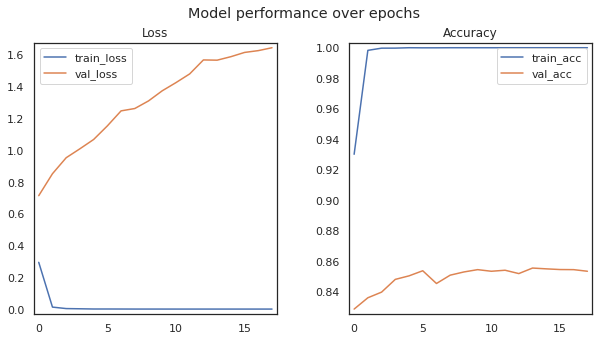

In [36]:
visualize_perf(history_v1)

In [37]:
def visualize_over_dataset(model):
    scores_train = model.evaluate(train_x, train_y_onehot, verbose=0)
    scores_val = model.evaluate(val_x, val_y_onehot, verbose=0)
    scores_test = model.evaluate(test_x, test_y_onehot, verbose=0)
    scores = [scores_train, scores_val, scores_test]
    df = pd.DataFrame(scores, index=['train', 'validation', 'test'], columns=model.metrics_names)
    df['acc'] = df['acc']*100
    df.rename({'acc': 'accuracy'}, axis=1, inplace=True)
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
    fig.subplots_adjust(hspace=0.5, wspace=0.2)

    sns.barplot(x=df.index, y='loss', data=df, ax=ax[0])
    sns.barplot(x=df.index, y='accuracy', data=df, ax=ax[1])
    ax[1].yaxis.set_major_formatter(mtick.PercentFormatter())

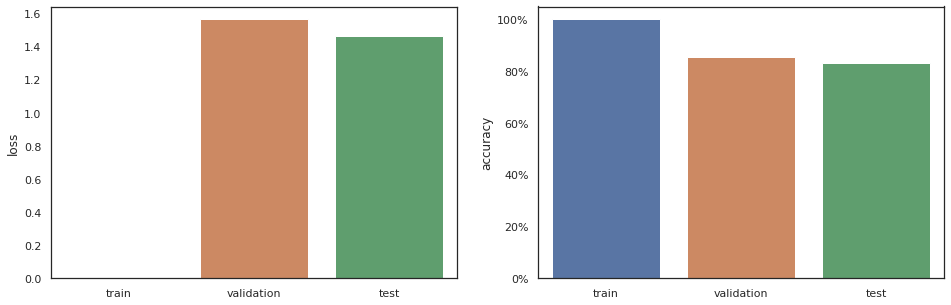

In [38]:
visualize_over_dataset(model_v1)

## e. Use Pretrained Model on Self-Supervised Task

In this section we will pretrain our model on the second task we suggested in 1c and will fine tune the trained model to the data. Reminder: we will be predicting temprature and first acceleration data of the chest IMU based on the other features.

In [39]:
list(subjects['102'].columns[1:])[18:22]

['IMU_chest1', 'IMU_chest2', 'IMU_chest3', 'IMU_chest4']

In [40]:
def ss_split_x_y(orig_x):
    l_serie = orig_x.shape[0]
    lookback = 4
    prd_mild = 2
    lookfrwd = 4
    
    x = np.concatenate([orig_x[:,:lookback,:], orig_x[:,lookback+prd_mild:,:]], axis=1)
    y = orig_x[:,lookback:lookback+prd_mild, 18:22]
    y = y.reshape(y.shape[0],-1)
    
    return x, y

In [41]:
ss_train_x, ss_train_y = ss_split_x_y(train_x)
ss_val_x, ss_val_y = ss_split_x_y(val_x)
ss_test_x, ss_test_y = ss_split_x_y(test_x)

We will initialize our ```ss_model```.<br> 
```ss``` for Self-Supervised.

In [42]:
def init_ss_model(input_shape, output_shape):

    inp = Input(shape=input_shape)
    X = LSTM(128)(inp)
    X = BatchNormalization()(X)
    X = Dropout(0.2)(X)
    X = Dense(64, activation='relu')(X)
    X = BatchNormalization()(X)
    X = Dropout(0.2)(X)
    X = Dense(32, activation='relu')(X)
    X = BatchNormalization()(X)
    X = Dropout(0.2)(X)
    out = Dense(output_shape, activation='relu')(X)

    model = Model(inp, outputs=out)

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model

In [43]:
ss_model, ss_history = train_model(init_ss_model,
                                   args=(
                                       (ss_train_x, ss_train_y),
                                       (ss_val_x, ss_val_y),
                                       (ss_test_x, ss_test_y)
                                        ),
                                   batch_size=1024,
                                   use_saved=False)

Epoch 1/20
926/926 [==============================] - 13s 14ms/step - loss: 0.6403 - mae: 0.5533 - val_loss: 0.6804 - val_mae: 0.4921 - lr: 0.0010
Epoch 2/20
926/926 [==============================] - 13s 14ms/step - loss: 0.5710 - mae: 0.4906 - val_loss: 0.6609 - val_mae: 0.4765 - lr: 0.0010
Epoch 3/20
926/926 [==============================] - 13s 14ms/step - loss: 0.5619 - mae: 0.4761 - val_loss: 0.6526 - val_mae: 0.4706 - lr: 0.0010
Epoch 4/20
926/926 [==============================] - 13s 14ms/step - loss: 0.5579 - mae: 0.4698 - val_loss: 0.6506 - val_mae: 0.4633 - lr: 0.0010
Epoch 5/20
926/926 [==============================] - 13s 14ms/step - loss: 0.5553 - mae: 0.4653 - val_loss: 0.6390 - val_mae: 0.4532 - lr: 0.0010
Epoch 6/20
926/926 [==============================] - 13s 14ms/step - loss: 0.5532 - mae: 0.4618 - val_loss: 0.6349 - val_mae: 0.4492 - lr: 0.0010
Epoch 7/20
926/926 [==============================] - 12s 13ms/step - loss: 0.5518 - mae: 0.4591 - val_loss: 0.6360 - 

We will use ```Dropout``` and ```BatchNormalization``` layers as regularizers that will help us in generalizing.

In [44]:
def init_trans_model(input_shape, output_shape):
    for layer in ss_model.layers:
        layer.trainable = False
    
    inp = ss_model.input
    X = ss_model.layers[-2].output
    X = Dense(32, activation='relu')(X)
    X = BatchNormalization()(X)
    X = Dropout(0.5)(X)
    X = Dense(16, activation='relu')(X)
    X = BatchNormalization()(X)
    X = Dropout(0.3)(X)
    out = Dense(output_shape, activation='softmax')(X)
    
    model = Model(inp, outputs=out)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

    return model

In [45]:
trans_model, trans_history = train_model(init_trans_model,
                                   args=(
                                       (ss_train_x, train_y_onehot),
                                       (ss_val_x, val_y_onehot),
                                       (ss_test_x, test_y_onehot)
                                        ),
                                   batch_size=1024,
                                   use_saved=False)

Epoch 1/20
926/926 [==============================] - 13s 14ms/step - loss: 2.0816 - acc: 0.2870 - val_loss: 1.8593 - val_acc: 0.3938 - lr: 0.0010
Epoch 2/20
926/926 [==============================] - 12s 13ms/step - loss: 1.8169 - acc: 0.3799 - val_loss: 1.8139 - val_acc: 0.4026 - lr: 0.0010
Epoch 3/20
926/926 [==============================] - 12s 13ms/step - loss: 1.7709 - acc: 0.3932 - val_loss: 1.8140 - val_acc: 0.3920 - lr: 0.0010
Epoch 4/20
926/926 [==============================] - 12s 13ms/step - loss: 1.7466 - acc: 0.3986 - val_loss: 1.8420 - val_acc: 0.3725 - lr: 0.0010
Epoch 5/20
924/926 [============================>.] - ETA: 0s - loss: 1.7285 - acc: 0.4037
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
926/926 [==============================] - 12s 13ms/step - loss: 1.7285 - acc: 0.4038 - val_loss: 1.8282 - val_acc: 0.3766 - lr: 0.0010
Epoch 6/20
926/926 [==============================] - 12s 13ms/step - loss: 1.7212 - acc: 0.4050 - val_lo

As can be seen from above cell, the transfer model did not do very well in this task, in comparison to earlier trials.

## f. Three Ways to Improve Our Model

Observing the results of ```model_v1``` we can surely see that out model suffer from overfitting. Thus, one improvemnt we can immediately suggest is add regularization to better generalize. In addition, out ```model_v1``` is quite basic (as  expected from the first iteration of a solution) so we wish to use more tools we learned in class to come up with more complex model. One more thing we consider as improvemnet is enlarging the ```look_back``` parameter.

Additional possible improvemnt is to train our model for more epoches. We will not implement this improvment as it may cause more overfitting.

Thus, we suggest 3 ways of improving our model:

- [X] Add regularizations - Dropout, BatchNormalization.
- [X] Improving the model architecture - more layers, bigger layers.
- [X] Enlarging our ```look_back``` parameter.
- [ ] Train for more epochs

## g. Improved Neural Network Model

In [46]:
use_saved = True
look_back = 20

if use_saved:
    train_x, train_y, val_x, val_y, test_x, test_y = joblib.load(f'./objects/nn_splits_lb{look_back}.sav')
else:
    train_x, train_y, val_x, val_y, test_x, test_y = split_train_val_test(look_back)
    joblib.dump((train_x, train_y, val_x, val_y, test_x, test_y), f'./objects/nn_splits_lb{look_back}.sav')
    
train_y_onehot = to_categorical(train_y)
val_y_onehot = to_categorical(val_y)
test_y_onehot = to_categorical(test_y)

In [47]:
def init_model_v2(input_shape, output_shape):

    inp = Input(shape=input_shape)
    X = LSTM(32)(inp)
    X = BatchNormalization()(X)
    X = Dropout(0.5)(X)
    X = Dense(64, activation='relu')(X)
    X = BatchNormalization()(X)
    X = Dropout(0.3)(X)
    out = Dense(output_shape, activation='softmax')(X)

    model = Model(inp, outputs=out)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

    return model

In [48]:
model_v2 = init_model_v2(train_x.shape[1:], train_y_onehot.shape[1])
model_v2.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 20, 53)]          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                11008     
_________________________________________________________________
batch_normalization_5 (Batch (None, 32)                128       
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                2112      
_________________________________________________________________
batch_normalization_6 (Batch (None, 64)                256       
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0   

In [49]:
model_v2, history = train_model(init_model_v2, batch_size=1024, use_saved=False)

Epoch 1/20
925/925 [==============================] - 13s 14ms/step - loss: 0.3140 - acc: 0.9042 - val_loss: 0.9446 - val_acc: 0.8208 - lr: 0.0010
Epoch 2/20
925/925 [==============================] - 13s 14ms/step - loss: 0.0140 - acc: 0.9967 - val_loss: 1.1415 - val_acc: 0.8378 - lr: 0.0010
Epoch 3/20
925/925 [==============================] - 20s 22ms/step - loss: 0.0079 - acc: 0.9983 - val_loss: 1.0260 - val_acc: 0.8695 - lr: 0.0010
Epoch 4/20
921/925 [============================>.] - ETA: 0s - loss: 0.0040 - acc: 0.9990
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
925/925 [==============================] - 12s 13ms/step - loss: 0.0040 - acc: 0.9990 - val_loss: 1.1100 - val_acc: 0.8787 - lr: 0.0010
Epoch 5/20
925/925 [==============================] - 17s 18ms/step - loss: 0.0023 - acc: 0.9994 - val_loss: 1.1926 - val_acc: 0.8754 - lr: 5.0000e-04
Epoch 6/20
925/925 [==============================] - 12s 13ms/step - loss: 0.0024 - acc: 0.9994 - va

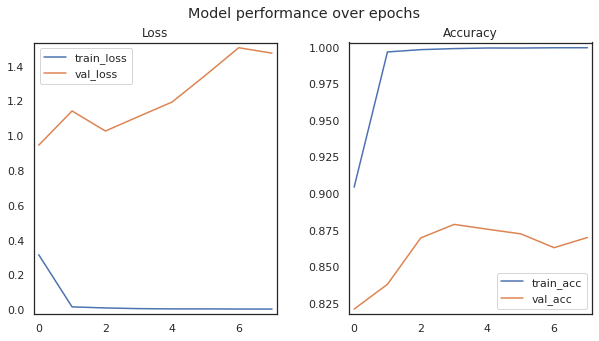

In [50]:
visualize_perf(history)

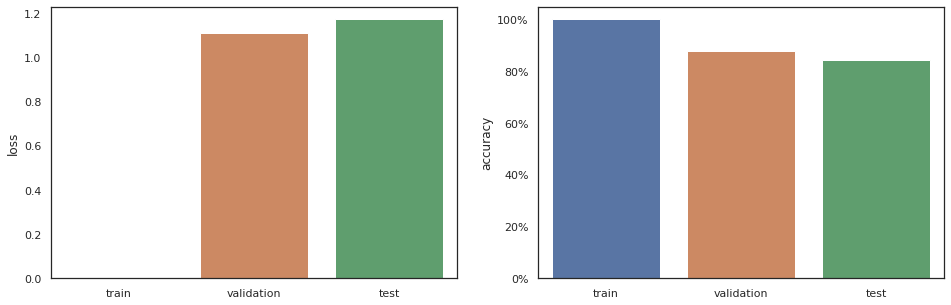

In [51]:
visualize_over_dataset(model_v2)

### Summary table

The following table summarizes our results in this research:

In [52]:
from prettytable import PrettyTable

results = PrettyTable()

results.field_names = ['Model', 'Test Accuracy', 'Run Time',
                       'Train Loss', 'Train Accuracy', 'Learning rate',
                       'Number of Epoches', 'Batch Size', 'Optimizer',
                       'Loss Function']
results.add_rows(
    [
        ["Logistic Regression\n(naive baseline)\n", 0.58, '05:06', 0.36, 0.89, '-', '-', '-', '-', 'categorical_crossentropy'],
        ["Random Forest\n(solid benchmark)\n", 0.68, '03:04', 0.003, 1.00, '-', '-', '-', '-', 'categorical_crossentropy'],
        ["model_v1\n",0.77, '06:51', 1.5779, 0.8175, 0.001, 20, 512, 'Adam', 'categorical_crossentropy'],
        ["Transfer Model\n(Self-Supervised)\n",'0.2984', '06:50', 1.7822, 0.3802, 0.001, 20, 1024, 'Adam', 'categorical_crossentropy'],
        ["model_v2\n",0.8803, '08:57', 1.9215, 0.8705, 0.001,20, 1024, 'Adam', 'categorical_crossentropy'],
    ]
)

print(results)

+---------------------+---------------+----------+------------+----------------+---------------+-------------------+------------+-----------+--------------------------+
|        Model        | Test Accuracy | Run Time | Train Loss | Train Accuracy | Learning rate | Number of Epoches | Batch Size | Optimizer |      Loss Function       |
+---------------------+---------------+----------+------------+----------------+---------------+-------------------+------------+-----------+--------------------------+
| Logistic Regression |      0.58     |  05:06   |    0.36    |      0.89      |       -       |         -         |     -      |     -     | categorical_crossentropy |
|   (naive baseline)  |               |          |            |                |               |                   |            |           |                          |
|                     |               |          |            |                |               |                   |            |           |              